## 情感得分

In [2]:
import re
import sys
import csv
import time

import pandas as pd
# pd.set_option?

import numpy as np
# np.set_printoptions(threshold=np.inf)  # 全部输出

import jieba
from datetime import datetime
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples 
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
import matplotlib.pyplot as plt

# 相关性
import seaborn as sns

# solve err
sns.set_style("darkgrid",{"font.sans-serif":['KaiTi', 'Arial']})

In [3]:
sentence_score_fname = r"D:\zhuomian\WeiBoTopic\Result\sentence_score.csv"
sentence_score = pd.read_csv(sentence_score_fname,sep=',',engine='python')
sentence_score

,原句,分词结果,去掉停用词结果,情感得分
0,世界杯盘点那些好听的世界杯主题曲🤗~2022年卡塔尔世界杯《HayyaHayya》🔥🔥🔥#卡...,世界杯/盘点/那些/好听/的/世界杯/主题曲/🤗/~/2022/年/卡塔尔/世界杯/《/Ha...,世界杯/盘点/好听/世界杯/主题曲/🤗/2022/卡塔尔/世界杯/HayyaHayya/🔥/...,2.338665
1,潘帕斯雄鹰必将翱翔在卡塔尔上空🇦🇷⚽️就想梅西夺冠，就想他封神，就想他捧起大力神杯如愿吧，如...,潘帕斯/雄鹰/必将/翱翔/在/卡塔尔/上空/🇦/🇷/⚽/️/就/想/梅西/夺冠/，/就/想/...,潘帕斯/雄鹰/翱翔/卡塔尔/上空/🇦/🇷/⚽/️/梅西/夺冠/封神/捧起/大力神杯/如愿/如...,10.859077
2,#卡塔尔世界杯#四年后东山再起加油阿根廷,#/卡塔尔/世界杯/#/四年/后/东山再起/加油/阿根廷,卡塔尔/世界杯/四年/东山再起/加油/阿根廷/,5.239788
3,世界杯这个主题曲真的一言难尽第一遍：什么玩意这是第二遍：好像还行第三遍：毒菇毒菇毒哒哒#卡塔...,世界杯/这个/主题曲/真的/一言难尽/第一遍/：/什么/玩意/这是/第二遍/：/好像/还/行...,世界杯/主题曲/真的/一言难尽/第一遍/玩意/这是/第二遍/好像/行/第三遍/毒菇/毒菇/毒...,-3.122426
4,今年我觉得巴西可能会赢#卡塔尔世界杯#,今年/我/觉得/巴西/可能/会/赢/#/卡塔尔/世界杯/#,今年/觉得/巴西/赢/卡塔尔/世界杯/,3.075256
...,...,...,...,...
12743,我记得你对我说过不止梅西帅，内马尔也超帅#卡塔尔世界杯#L可乐橘子气泡水的微博视频,我/记得/你/对/我/说/过/不止/梅西帅/，/内马尔/也/超帅/#/卡塔尔/世界杯/#/L...,记得/梅西帅/内马尔/超帅/卡塔尔/世界杯/L/可乐/橘子/气泡/水/微博/,2.817998
12744,#卡塔尔世界杯##乌拉圭0比0韩国#双方势均力敌，🇰🇷甚至能把82踢红温了就是这俩队的反击看...,#/卡塔尔/世界杯/##/乌拉圭/0/比/0/韩国/#/双方/势均力敌/，/🇰/🇷/甚至/能...,卡塔尔/世界杯/##/乌拉圭/韩国/双方/势均力敌/🇰/🇷/82/踢/红温/这俩/队/反击/...,1.382951
12745,今天凌晨零点看C罗，3点看内马尔⚽#卡塔尔世界杯##C罗##内马尔#,今天/凌晨/零点/看/C/罗/，/3/点/看/内/马尔/⚽/#/卡塔尔/世界杯/##/C/罗...,今天/凌晨/零点/C/罗/点/马尔/⚽/卡塔尔/世界杯/##/C/罗/##/内马尔/,2.580642
12746,明凌晨0点卡塔尔世界杯小组赛H组第1轮葡萄牙🇵🇹VS🇬🇭加纳从倒数百天到今天的这一刻即将来临...,明/凌晨/0/点/卡塔尔/世界杯/小组赛/H/组第/1/轮/葡萄牙/🇵/🇹/VS/🇬/🇭/加...,明/凌晨/点/卡塔尔/世界杯/小组赛/H/组第/轮/葡萄牙/🇵/🇹/VS/🇬/🇭/加纳/倒/...,-1.681694


In [4]:
sentence_score_sorted = sentence_score.sort_values(by=["情感得分"], ascending=False)
sentence_score_sorted.head(3)['原句']

6031     健康|世界杯已经开始~小心这些健康“红牌”！实用自救锦囊请收好#卡塔尔世界杯##熬夜##保养...
6308     【#世界杯#|D组预告今斗澳洲法国展开卫冕首击】卫冕的法国(高卢雄鸡)在周二(22日)的卡塔...
10934    好了，平静了一点，可以好好说说这场球了。开场第一分钟，就能看出来日本的节奏比德国快，京多安被...
Name: 原句, dtype: object

# 聚类算法


常用聚类算法对比

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)  


## K-Means实现  


### K-Means介绍

K-Means 通常被称为 Lloyd’s algorithm（劳埃德算法）

算法有三个步骤

第一步是选择 initial centroids （初始质心），最基本的方法是从 X 数据集中选择k个样本。初始化完成后，K-Means 由两个其他步骤之间的循环组成。 

第二步将每个样本分配到其 nearest centroid （最近的质心）。 

第三步通过取分配给每个先前质心的所有样本的平均值来创建新的质心。计算旧的和新的质心之间的差异，并且算法重复这些最后的两个步骤，直到该值小于阈值。换句话说，算法重复这个步骤，直到质心不再显著移动。
    
### 安装sklearn

cmd 指令 `pip install scikit-learn`

安装之前需要numpy和scipy库

In [5]:
sentence_score['情感得分']
# pandas.core.series.Series

0         2.338665
1        10.859077
2         5.239788
3        -3.122426
4         3.075256
           ...    
12743     2.817998
12744     1.382951
12745     2.580642
12746    -1.681694
12747     1.488529
Name: 情感得分, Length: 12748, dtype: float64

In [6]:
data=np.array(sentence_score['情感得分'])
print(data)
# numpy.ndarray

[ 2.33866454 10.85907686  5.23978831 ...  2.58064169 -1.68169408
  1.48852874]


In [7]:
# 数组不能进行K-Means计算。先遍历数组 再转换成列表
data=[[i] for  i in  data]
data

[[2.338664544118],
 [10.859076856131002],
 [5.239788314281],
 [-3.1224264582660006],
 [3.075255685042],
 [10.501787542973402],
 [15.444627986988],
 [-0.1592254237101998],
 [23.982481902316],
 [-0.8835982308649999],
 [-8.2296806494298],
 [18.64724714917],
 [12.217440279987253],
 [26.3513574902131],
 [1.751957235251],
 [3.9170380510168],
 [59.32429021995056],
 [5.214416717312001],
 [10.434881198482],
 [-0.7019892228360001],
 [3.309373836333],
 [11.462495972847998],
 [10.220140536996],
 [9.319453121875],
 [13.44878959881],
 [8.2861874713652],
 [3.678732592106],
 [5.918667729138001],
 [6.289111199815899],
 [9.6528929545616],
 [35.905446187093055],
 [-1.4216240510772002],
 [1.4581044910560002],
 [2.1725475623120003],
 [10.448768949746002],
 [3.670463627032],
 [9.11181898896],
 [3.3474405688870004],
 [1.9039846128239],
 [8.024909317247001],
 [2.8776047424327],
 [11.76966033469],
 [-0.5903533135555001],
 [0.6939225367520001],
 [3.0574489465920003],
 [-0.2358967175639998],
 [2.7247917388759],


### K-Means聚类

In [8]:
# 进行kmeans聚类。先聚4类
julei=KMeans(n_clusters=4) 

# 提供数据
julei.fit(data)

C:\Users\sakura\AppData\Local\Temp\ipykernel_11336\852124640.py:5: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  julei.fit(data)


KMeans(n_clusters=4)

In [9]:
# 获得聚类标签，即获得每个数据对应的每一类

label=julei.labels_ 
print(label)

# 获得聚类中心
center=julei.cluster_centers_
print(center)

[2 2 2 ... 2 2 2]
[[4.82344960e+07]
 [1.76829117e+25]
 [6.81574400e+06]
 [3.40787200e+06]]


###  二维聚类

In [16]:
data1=datA['Wind']
data1=np.array(data1)

data2=datA['Temp']
data2=np.array(data2)

DATA2= np.vstack((data1,data2)).T

print(DATA2)

In [20]:
julei=KMeans(n_clusters=4) #进行kmeans聚类

julei.fit(DATA2) #对聚类的数据进行聚类

label=julei.labels_ 
print(label)

In [28]:
lkxs=silhouette_samples(data,label)
print(lkxs)

[1. 1. 1. ... 1. 1. 1.]


### 有效性评价

**有效性评价标准**

聚类算法属于无监督学习方法，不同的聚类数对聚类结果影响很大。所以需要进行聚类有效性评价。聚类评价指标比较多，常用的有：Rand指数、轮廓系数（Silhouette Coefficient）、Calinski-Harabaz 指数等等



**轮廓系数进行聚类评价**

轮廓系数处于-1至1，越大表示簇间相似度高而不同簇相似度低，即聚类效果越好。

In [27]:
# 轮廓系数求均值，约接近1，效果越好
means=np.mean(lkxs)
print(means)

0.9999215563225604


轮廓系数的均值就能表示不同聚类数的好坏，因为我们可以写一个循环来计算聚类数从2到n-1的轮廓系数进行聚类评价

In [13]:
def juleipingjia(n):
    # 计算每一个聚类下的轮廓系数
    julei=KMeans(n_clusters=n)
    julei.fit(data)
    label=julei.labels_
    lkxs=silhouette_samples(data,label,metric='euclidean')
    means=np.mean(lkxs)
    return means

In [24]:
start_time=time.perf_counter()
scores = []
ks=[]
for k in range(2,23):
    means=juleipingjia(k)
    scores.append(means)
    ks.append(k)
    
end_time=time.perf_counter()
print("Running time:",(end_time-start_time))  #输出程序运行时间

C:\Users\sakura\AppData\Local\Temp\ipykernel_11336\2448734064.py:3: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  julei.fit(data)
C:\Users\sakura\AppData\Local\Temp\ipykernel_11336\2448734064.py:3: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  julei.fit(data)
C:\Users\sakura\AppData\Local\Temp\ipykernel_11336\2448734064.py:3: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  julei.fit(data)
C:\Users\sakura\AppData\Local\Temp\ipykernel_11336\2448734064.py:3: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  julei.fit(data)
C:\Users\sakura\AppData\Local\Temp\ipykernel_11336\2448734064.py:3: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7

Running time: 43.403764600000045


分别计算轮廓系数就能看出最佳聚类数

In [25]:
# 找出最大值，最大值下标
scores_arr = np.array(scores)
ks_arr = np.array(ks)

max_k = ks_arr[scores_arr.argmax()]
print('最佳聚类数为', max_k)

最佳聚类数为 2


Text(0, 0.5, 'scores')

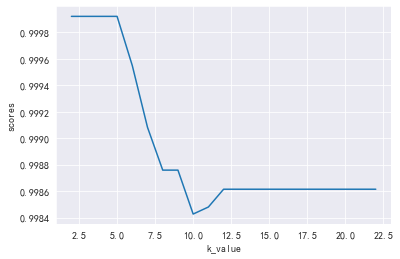

In [26]:
# 绘图  参数：(自变量，因变量)
plt.plot(ks, scores)
plt.xlabel('k_value')
plt.ylabel('scores')